In [1]:
import numpy as np
import pandas as pd
import math
from scipy import special, signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import laspy
from scipy.stats import linregress
import uncertainties
import scipy as sp

In [3]:
testfile = "C:\\Users\\sgpq58\\Research_Share\\Post Doctoral Research\\chicken_springs\\prof1.csv"
arr = np.genfromtxt(testfile, delimiter=",", skip_header=1)
x = arr[:, 0]
z = arr[:, 1]
sgn = np.sign(x)

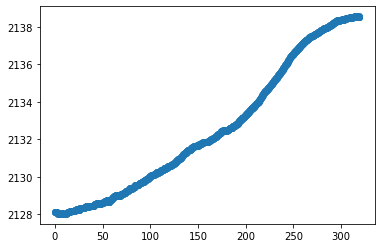

In [4]:
plt.scatter(x, np.flip(z))

def init_geom(x, H, b):
    z = ((H * np.sign(x)) + (b * (x)))
    return z

In [5]:
def fit_prof_mid(x, z):
    if z[0] > z[-1]:
        I = np.argsort(x)
        x = x[I]
        z = z[I]
        z = np.flip(z)
    if x.shape[0] > 5000:
        samp_step = 100
        n_out_rows = (x.shape[0] // samp_step) + 1
    else:
        samp_step = 1
        n_out_rows = x.shape[0]
    output = np.empty((n_out_rows, 6))
    inc = 0
    for i in range(0, x.shape[0], samp_step):
        midz = z[i]
        midx = x[i]
        z1 = z - midz
        x1 = x - midx
        popt, pcov = curve_fit(init_geom, x1, z1)
        rmse = np.sqrt(np.mean((z1 - init_geom(x1, *popt))**2))
        mean_resid = np.mean(z1 - init_geom(x1, *popt))
        outrow = [midx, midz, popt[0], popt[1], rmse, mean_resid]
        output[inc, :] = outrow
        inc += 1

    minrmse = np.amin(output[:, 4])
    opt_ind = np.where(output[:, 4] == minrmse)
    opt_results = output[opt_ind, :][0]
    opt_midx = opt_results[0, 0]
    opt_midz = opt_results[0, 1]
    H_guess = opt_results[0, 2]
    b_guess = opt_results[0, 3]
    return opt_midx, opt_midz, H_guess, b_guess

In [6]:
opt_midx, opt_midz, H_guess, b_guess = fit_prof_mid(x, z)

In [7]:
def scarp_1e(x, H, D, b):
    u = ((H) * special.erf(x / (2 * np.sqrt(D)))) + (b * x)
    return u


def fit_1event(x, z, xmid, zmid, b_guess, H_guess):
    if z[0] > z[-1]:
        I = np.argsort(x)
        x = x[I]
        z = z[I]
        z = np.flip(z)
    x1 = x - xmid
    z1 = z - zmid
    H_min = 0
    H_max = H_guess * 2
    b_min = b_guess - (b_guess * 1.5)
    b_max = b_guess + (b_guess * 1.5)
    D_min = 0
    D_max = 500
    D_guess = 50
    bound1 = ([H_min, D_min, b_min], [H_max, D_max, b_max])
    guess = [H_guess, D_guess, b_guess]
    popt, pcov = curve_fit(scarp_1e, x1, z1, p0=guess, bounds=bound1)
    H = popt[0]
    D = popt[1]
    b = popt[2]
    return H, D, b

In [8]:
H1, D1, b1 = fit_1event(x, z, opt_midx, opt_midz, b_guess, H_guess)


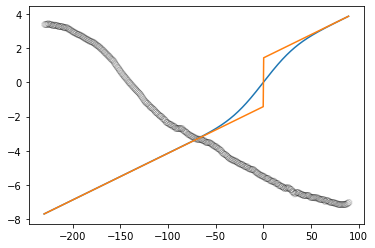

In [9]:
x1 = x - opt_midx
z1 = z - opt_midz
plt.plot(x1, z1, 'ok', mew=0.05, mfc='none')
plt.plot(x1, scarp_1e(x1, H1, D1, b1))
plt.plot(x1, init_geom(x1, H1, b1))
plt.savefig('./one_event.png', dpi=300)

In [10]:
def scarp_ss(x, H, D, b ):
    Q = H / D
    u = (H * special.erf(x / (2 * np.sqrt(D)))) + ((Q * x**2)/2)*(special.erf(x / (2*np.sqrt(D))) - np.sign(x)) + \
        ((Q * x) * np.sqrt(D / math.pi) * np.exp((-1 * x**2)/(4 * D))) + (b * x)
    return u


def fit_ss_uplift(x, z, xmid, zmid, b_guess, H_guess):
    if z[0] > z[-1]:
        I = np.argsort(x)
        x = x[I]
        z = z[I]
        z = np.flip(z)
    x1 = x - xmid
    z1 = z - zmid
    H_min = 0
    H_max = H_guess * 2
    b_min = b_guess - (b_guess * 1.5)
    b_max = b_guess + (b_guess * 1.5)
    D_min = 0
    D_max = 5000
    D_guess = 150
    bound1 = ([H_min, D_min, b_min], [H_max, D_max, b_max])
    guess = [H_guess, D_guess, b_guess]
    popt, pcov = curve_fit(scarp_ss, x1, z1, p0=guess, bounds=bound1)
    H = popt[0]
    D = popt[1]
    b = popt[2]
    return H, D, b

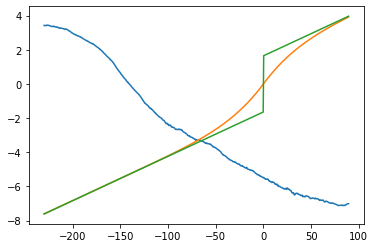

In [11]:
H2, D2, b2 = fit_ss_uplift(x, z, opt_midx, opt_midz, b_guess, H_guess)

plt.plot(x1, z1)
plt.plot(x1, scarp_ss(x1, H2, D2, b2))
plt.plot(x1, init_geom(x1, H2, b2))

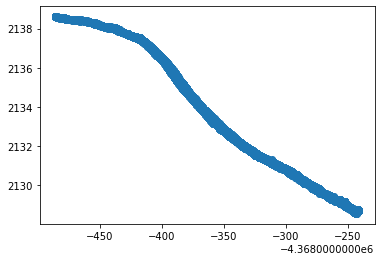

In [2]:
lasfile = laspy.read("./cs_test2.las")


lin_results = linregress(lasfile.x, lasfile.y)
azimuth = math.atan(lin_results.slope)
c, s = np.cos(azimuth), np.sin(azimuth)
R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
pts = np.array([lasfile.x, lasfile.y, lasfile.z]).T
# new_pts = np.dot(pts, R.T)
new_pts = pts @ R.T
plt.plot(new_pts[:, 0], new_pts[:, 2], 'o')
x = new_pts[:, 0] - new_pts[0, 0]
z = new_pts[:, 2]

In [13]:
opt_midx, opt_midz, H_guess, b_guess = fit_prof_mid(x, z)

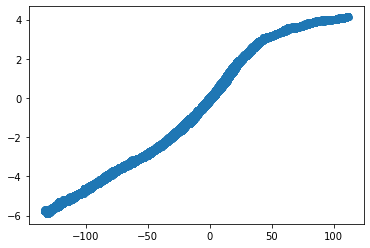

In [14]:
I = np.argsort(x)
x = x[I]
z = z[I]
z1 = np.flip(z) - opt_midz
x1 = x - opt_midx
plt.plot(x1, z1, 'o')


In [15]:
Hp, Dp, bp = fit_1event(x, z, opt_midx, opt_midz, b_guess, H_guess)

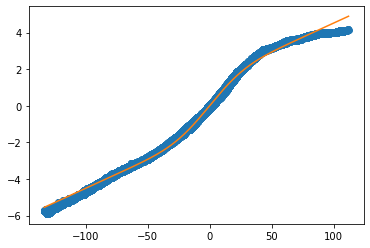

In [16]:
plt.plot(x1, z1, 'o')
plt.plot(x1, scarp_1e(x1, Hp, Dp, bp))

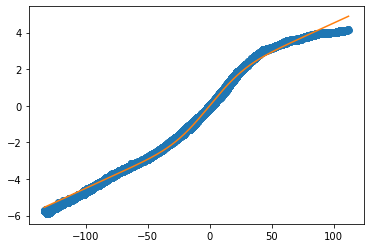

In [17]:
popt, pcov = curve_fit(scarp_1e, x1, z1 )
(H, D, b) = uncertainties.correlated_values(popt, pcov)
plt.plot(x1, z1, 'o')
plt.plot(x1, scarp_1e(x1, H.n, D.n, b.n))#%%


In [31]:
scarpdata = np.vstack((x,z))
scarpdata = scarpdata.T

In [37]:
scarpnn = pd.DataFrame(data=scarpdata, index=scarpdata[:, 0], columns=['x', 'z'])


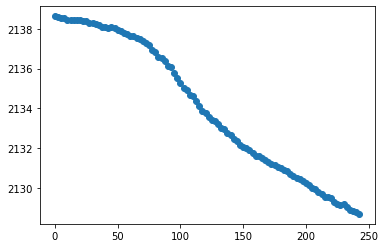

In [97]:
x_max = np.floor(x.max())
new_x = np.arange(0, x_max, 2.5)
gfg = sp.interpolate.interp1d(x, z)
z_new = gfg(new_x)
plt.plot(new_x, z_new, 'o')

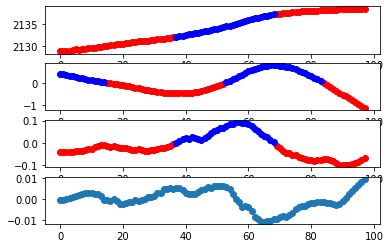

In [221]:
z_filt = signal.savgol_filter(signal.detrend(np.flip(z_new)), 17, 1)
z_slope = signal.savgol_filter(signal.detrend(np.flip(z_new)), 17, 3, deriv=1)
z_grad = signal.savgol_filter(signal.detrend(np.flip(z_new)), 17, 3, deriv=2)
x_samp = np.arange(z_filt.shape[0])
plt.subplot(4,1,1)
plt.plot(x_samp[z_slope < 0], np.flip(z_new)[z_slope < 0], 'or')
plt.plot(x_samp[z_slope >= 0], np.flip(z_new)[z_slope >= 0], 'ob')
plt.subplot(4,1,2)
plt.plot(x_samp[z_filt < 0], z_filt[z_filt < 0], 'or')
plt.plot(x_samp[z_filt >= 0], z_filt[z_filt >= 0], 'ob')
plt.subplot(4,1,3)
plt.plot(x_samp[z_slope < 0], z_slope[z_slope < 0], 'or')
plt.plot(x_samp[z_slope >= 0], z_slope[z_slope >= 0], 'ob')
plt.subplot(4,1,4)
plt.plot(z_grad, 'o')

array([1.45679425e+01, 1.02460079e+01, 2.20000000e+01, 2.79304566e+01,
       2.93750680e-14, 8.60000000e+01])

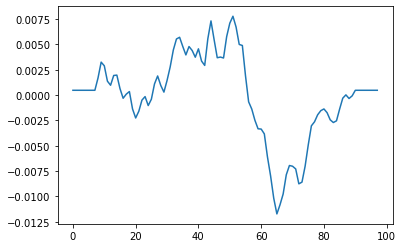

In [187]:
x_new1 = new_x - opt_midx
z_new1 = np.flip(z_filt) - opt_midz
#z_slope = np.gradient(np.gradient(z_new1, x_new1), x_new1)
z_slope_detrend = signal.detrend(z_slope)
plt.plot(np.gradient(z_slope_detrend), '-')

peaks, _ = signal.find_peaks(z_slope_detrend)
results_full = signal.peak_widths(z_slope_detrend, peaks, rel_height=1)
results_full[2]

In [184]:
def dsp_scarp_identify(x, z):
    x_max = np.floor(x.max())
    x_new = np.arange(0, x_max, 0.5)
    gfg = sp.interpolate.interp1d(x, z)
    z_new = gfg(x_new)
    z_filt = signal.savgol_filter(np.flip(z_new), 17, 1)
    z_slope = signal.savgol_filter(np.flip(z_new), 17, 1, deriv=1)
    z_slope_detrend = signal.detrend(z_slope)
    peaks, _ = signal.find_peaks(z_slope_detrend)
    peak_width_res = signal.peak_widths(z_slope_detrend, peaks, rel_height=1)
    max_peak = peaks[np.argmax(peak_width_res[0])]
    max_peak_width = np.max(peak_width_res[0])
    opt_midx = x_new[max_peak]
    opt_midz = z_new[max_peak]
    scarp_start = x_new[round(max_peak - (max_peak_width / 2))]
    scarp_end = x_new[round(max_peak + (max_peak_width / 2))]
    return max_peak, max_peak_width, opt_midx, opt_midz, scarp_start, scarp_end

In [185]:
max_peak, max_peak_width, midxnn, midznn, scarp_start, scarp_end = dsp_scarp_identify(x, z)

IndexError: index 493 is out of bounds for axis 0 with size 490

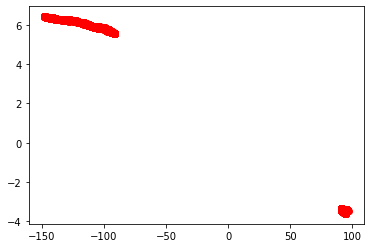

In [180]:
x1 = x - midxnn
z1 = z - midznn
scarp_start = scarp_start - midxnn
scarp_end = scarp_end - midxnn
scarp_start_ind = x1 < scarp_start
scarp_end_ind = x1 > scarp_end
upper_slopex = x1[scarp_start_ind]
upper_slopez = z1[scarp_start_ind]
lower_slopex = x1[scarp_end_ind]
lower_slopez = z1[scarp_end_ind]
# plt.plot(x1, z1, 'o')
plt.plot(upper_slopex, upper_slopez, 'o', color='r')
plt.plot(lower_slopex, lower_slopez, 'o', color='r')